## Trend Example 2

In [1]:
import sys
import os

sys.path.append(
    os.path.abspath(
        os.path.join(os.path.dirname(os.path.realpath("__file__")), "..", "..")
    )
)

In [2]:
import numpy as np
import pandas as pd

In [3]:
import warnings

warnings.filterwarnings("ignore")

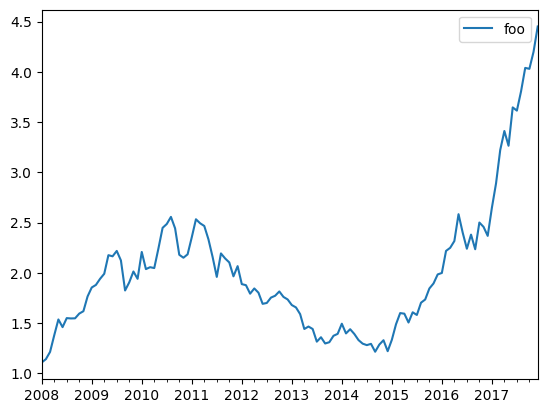

In [4]:
np.random.seed(0)
returns = np.random.normal(0.08 / 12, 0.2 / np.sqrt(12), 12 * 10)
pdf = pd.DataFrame(
    np.cumprod(1 + returns),
    index=pd.date_range(start="2008-01-01", periods=12 * 10, freq="m"),
    columns=["foo"],
)

pdf.plot();

In [10]:
from bt.algos.flow import RunMonthly
from bt.algos.portfolio_ops import Rebalance
from bt.core.algo_base import Algo
from bt.core.strategy import Strategy
from bt.engine.backtest import Backtest
import bt

In [8]:
runMonthlyAlgo = RunMonthly()
rebalAlgo = Rebalance()


class Signal(Algo):
    """

    Mostly copied from StatTotalReturn

    Sets temp['Signal'] with total returns over a given period.

    Sets the 'Signal' based on the total return of each
    over a given lookback period.

    Args:
        * lookback (DateOffset): lookback period.
        * lag (DateOffset): Lag interval. Total return is calculated in
            the inteval [now - lookback - lag, now - lag]

    Sets:
        * stat

    Requires:
        * selected

    """

    def __init__(self, lookback=pd.DateOffset(months=3), lag=pd.DateOffset(days=0)):
        super(Signal, self).__init__()
        self.lookback = lookback
        self.lag = lag

    def __call__(self, target):
        selected = "foo"
        t0 = target.now - self.lag

        if target.universe[selected].index[0] > t0:
            return False
        prc = target.universe[selected].loc[t0 - self.lookback : t0]

        trend = prc.iloc[-1] / prc.iloc[0] - 1
        signal = trend > 0.0

        if signal:
            target.temp["Signal"] = 1.0
        else:
            target.temp["Signal"] = 0.0

        return True


signalAlgo = Signal(pd.DateOffset(months=12), pd.DateOffset(months=1))


class WeighFromSignal(Algo):
    """
    Sets temp['weights'] from the signal.
    Sets:
        * weights

    Requires:
        * selected

    """

    def __init__(self):
        super(WeighFromSignal, self).__init__()

    def __call__(self, target):
        selected = "foo"
        if target.temp["Signal"] is None:
            raise (Exception("No Signal!"))

        target.temp["weights"] = {selected: target.temp["Signal"]}
        return True


weighFromSignalAlgo = WeighFromSignal()

In [11]:
s = Strategy("example1", [runMonthlyAlgo, signalAlgo, weighFromSignalAlgo, rebalAlgo])

t = Backtest(s, pdf, integer_positions=False, progress_bar=True)
res = bt.run(t)

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.65it/s]


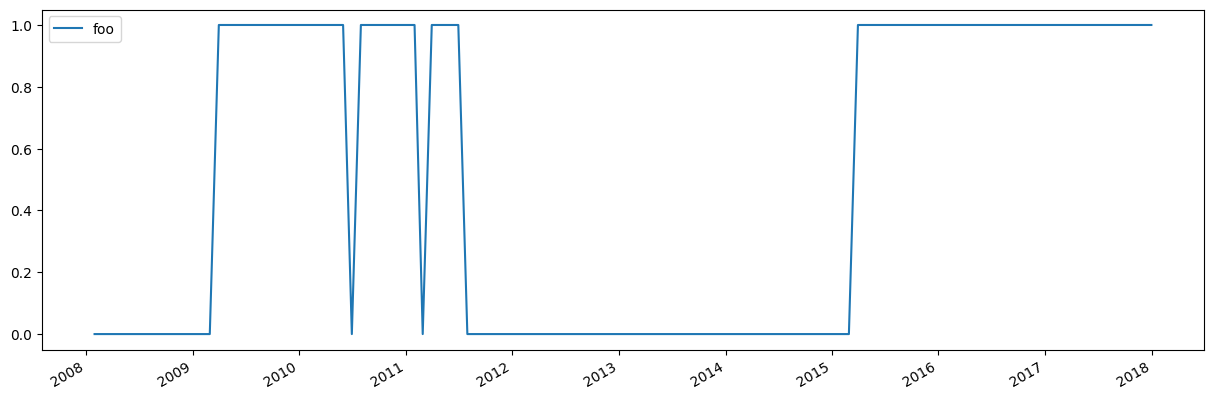

In [12]:
res.plot_security_weights();

In [13]:
t.positions

,foo
2008-01-30,0.000000
2008-01-31,0.000000
2008-02-29,0.000000
2008-03-31,0.000000
2008-04-30,0.000000
...,...
2017-08-31,631321.251898
2017-09-30,631321.251898
2017-10-31,631321.251898
2017-11-30,631321.251898


In [14]:
res.prices.tail()

,example1
2017-08-31,240.302579
2017-09-30,255.046653
2017-10-31,254.464421
2017-11-30,265.182603
2017-12-31,281.069771


In [15]:
res.stats

,example1
start,2008-01-30 00:00:00
end,2017-12-31 00:00:00
rf,0.0
total_return,1.810698
cagr,0.109805
max_drawdown,-0.267046
calmar,0.411186
mtd,0.05991
three_month,0.102033
six_month,0.22079
